$$
\newcommand{P}[1]{\mathrm{P}\left( #1 \right)}
\newcommand{Pc}[2]{\mathrm{P}\left( #1 \mid #2 \right)}
\newcommand{Ec}[2]{\mathrm{E}\left( #1 \mid #2 \right)}
\newcommand{In}[2]{ #1 \perp\!\!\!\perp #2}
\newcommand{Cin}[3]{ #1 \perp\!\!\!\perp #2 \, | \, #3}
\newcommand{do}[1]{\mathrm{do}\left( #1 \right)}
\newcommand{\ci}{\perp\!\!\!\perp}
$$

# Counterfactual Models and Causal Effects

Day 3 Module 2

### Potential Outcome Framework

As discussed in the previous secsion, for a study with a binary treatment variable $A \in \{0, 1\}$, we can introduce two new random variables to the system: $Y^{0}$ and $Y^{1}$, under the counterfactual outcome framework. We imagine that these variables exist, and can be treated as any other random variable - the only difference is that they are never directly observed. 

* This shifts the problem from one about how distributions change under the intervention, to one about data drawn i.i.d. from some underlying distribution with [missing values](https://en.wikipedia.org/wiki/Missing_data). 

| index $i$ | $X_i$ | $A_i$ | $Y_i$ | $Y_i^0$ | $Y_i^1$ |
| --- | --- | --- | --- | --- | --- | 
| 1 | 0 | 0 | 4 | ? | ? |
| 2 | 0 | 0 | 3 | ? | ? |
| 3 | 0 | 0 | 5 | ? | ? |
| 4 | 0 | 1 | 8 | ? | ? |
| 5 | 1 | 0 | 2 | ? | ? |
| 6 | 1 | 0 | 4 | ? | ? |
| 7 | 1 | 1 | 8 | ? | ? |
| 8 | 1 | 1 | 6 | ? | ? |

#### Identification Assumptions (for the missing counterfactuals)

*  Consistency: $Y_i^a = Y_i$ if $A_i=a$.

| index $i$ | $X_i$ | $A_i$ | $Y_i$ | $Y_i^0$ | $Y_i^1$ |
| --- | --- | --- | --- | --- | --- | 
| 1 | 0 | 0 | 4 | <font color='red'>4</font> | ? |
| 2 | 0 | 0 | 3 | <font color='red'>7</font> | ? |
| 3 | 0 | 0 | 5 | <font color='red'>2</font> | ? |
| 4 | 0 | 1 | 8 | ? | <font color='red'>8</font> |
| 5 | 1 | 0 | 2 | <font color='red'>2</font> | ? |
| 6 | 1 | 0 | 4 | <font color='red'>4</font> | ? |
| 7 | 1 | 1 | 8 | ? | <font color='red'>8</font> |
| 8 | 1 | 1 | 6 | ? | <font color='red'>6</font> |

*  Positivity: $0 < \Pc {A_i=1} {X_{1,i},X_{2,i},\cdots,X_{p,i}} < 1$, for all values of $X_{1,i},X_{2,i}, \cdots, X_{p,i}$ that occur in the study population.
    - In the example, $\Pc{A_i=1}{X_i=0}=0.25$ and $\Pc{A_i=1}{X_i=1}=0.5$, both arms exist on each level of $X$.

*  Conditional Exchangeability (No Unmeasured Confounding Assumption, NUCA): $\{Y_i^0, Y_i^1\} \ci A_i \vert \{X_{1,i},X_{2,i}, \cdots, X_{p,i}\}$
    - $P(A_i, Y_i^{0}, Y_i^{1}| X_i) = P(A_i|X_i)P(Y_i^{0}, Y_i^{1}|X_i)$ or $E[Y_i^{1}|A_i=1, X_i] = E[Y_i^{1}| X_i] = E[Y_i^{1}|A_i=1, X_i]$, at given level of $X_i$, we may use information from one treatment arm to impute for the other arm.
    - If we want to estimate the ATE using observational data, we need to use other information we have about the samples - specifically we need to **assume** that we have enough additional information to completely explain the choice of treatment each subject.
    - This means that the observed treatment a sample receives, $A$, is completely explained by $X$. This is sometimes called the ["ignorability" assumption](https://en.wikipedia.org/wiki/Ignorability).


# Data Example: Causal Effect

Often we do not care about the full distribution of the counterfactuals, and it is of more interest to estimate the [Average Treatment Effect (ATE)](https://en.wikipedia.org/wiki/Average_treatment_effect):

$\theta = E[Y^{1} - Y^{0}]$

If we just try and estimate this quantity from the observational distribution, we get (the association):

$\alpha = E[Y|X=1] - E[Y|X=0]$

If we model $Y$ against $A$, we get $\alpha$, if we model $Y^a$ we get $\theta$ (you may have missing data in this model)

* When randomization occurs, $\theta = \alpha$
* In observational studies, the two quantities are not equal in general.

**This can be illustrated from the following data example:**

Suppose we are interested in studying the effect of smoking on lung function. We collect information from $n=500$ subjects and record whether or not the person is a current and/or former smoker ($A=1$ for smoker, $A=0$ for non-smoker) at the begining of the study, and their lung function score $Y$ (can be considered as a continuous measure) at the end of study, and we also record a confounding variable $X$ (e.g. age or measure of certain biomarker), which affects both the smoking status and the lung function.

In [2]:
from __future__ import division
from sklearn.preprocessing import PolynomialFeatures

import numpy as np
np.warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")

%matplotlib inline

We can use the following code to generate a hypothetical dataset from such a study.

In the simulation, for subject $i$ ($i=1,\cdots,500$), we generate 

* the confounder $X_i \sim N(0,1)$;
* binary treatment indicator $A$ from $\text{logit}[\Pc{A_i=1}{X_i}]=1 + 2 X_i$;
* the (true) counterfactuals: 
    - $Y^0_i = 2 X_i + \epsilon_i$
    - $Y^1_i = 0.5 + 2 X_i + \epsilon_i$
    - where $\epsilon_i \sim N(0,0.3^2)$
* the observed outcome $Y_i = Y^1_i \times A_i + Y^0_i \times (1 - A_i)$

In [4]:
"""
Data Example 1
  
"""
n_samples = 500
X = np.random.normal(size=n_samples)
p_a = np.exp(1 + 2 * X)/(1 + np.exp(1 + 2 * X))
A = np.random.binomial(n=1, p=p_a, size=n_samples)
eY = 0.3 * np.random.normal(size=n_samples)
Y0 = 2 * X + eY
Y1 = Y0 + 0.5
Y = np.where(A == 0, Y0, Y1)

example_smk = pd.DataFrame({"X":X, "A":A, "Y":Y, "Y0":Y0, "Y1":Y1})
example_smk.head()

,A,X,Y,Y0,Y1
0,1,0.637177,1.945359,1.445359,1.945359
1,0,-0.533677,-1.120937,-1.120937,-0.620937
2,0,-0.939055,-2.222518,-2.222518,-1.722518
3,1,0.627984,1.694888,1.194888,1.694888
4,1,1.185025,2.817104,2.317104,2.817104


Can we conclude that smoking led to worse lung function outcome? We may estimate, $\alpha$, the different in mean of the two treatment groups:

In [8]:
"""
Estimate the difference in means between two groups.
  
"""
ctrl_grp = example_smk[example_smk.A == 0]
trt_grp = example_smk[example_smk.A == 1]
 
alpha = trt_grp.Y.mean() - ctrl_grp.Y.mean()
alpha_err = 1.96 * np.sqrt(
        trt_grp.Y.var() / trt_grp.shape[0] + 
        ctrl_grp.Y.var() / ctrl_grp.shape[0])
  
print("estimated_effect: {:.3f}".format(alpha), "; standard_error: {:.3f}".format(alpha_err))

estimated_effect: 3.026 ; standard_error: 0.286


Yet, the link we are seeing, is a correlation, but it does not neccessarily provide us the causal link. For this simulated dataset, we actually know both counterfactuals, so we can calculate ATE $\theta$ as

In [9]:
"""
Estimate the causal treatment effect.
  
"""
theta = example_smk.Y1.mean() - example_smk.Y0.mean()
print("true ATE: {:.3f}".format(theta))

true ATE: 0.500


Thus, we can see generally $\theta \neq \alpha$

As mentioned earlier, two related quantities for causal treatment effect that we can also consider are:

* The average causal affect in the treated (ATT): $\text{ATT} = E[Y_i^1 − Y_i^0\,\vert\, A_i=1]$

* The average causal affect in the untreated (ATU, or ATC as 'in controls'): $\text{ATU} = E[Y_i^1 − Y_i^0\,\vert\, A_i=0]$

One way to interpret ATU is as a measure of the effect of treating only samples which wouldn't naturally be treated, and vice versa for ATT. Depending on the goal of your study, they may be more natural measures of what you care about.

## The counterfactual model

However, in observational studies, we will not observe the counterfactuals as in this simulation example, counterfactual models provide tools to estimate the counterfactuals, as well as the causal quantities that related to them. For example, we can build estimators: 
 
 - $\hat{Y}^{0}(X) = E[Y|X, A=0]$
 - $\hat{Y}^{1}(X) = E[Y|X, A=1]$. 
 
If we can model these two quantities, we can estimate the ATE as:

$\hat\theta = \frac{1}{N}\sum_{i=1}^N [\hat{Y}^{1}(x_{i}) - \hat{Y}^{0}(x_{i})]$

The success of this approach depends on how well we can model the potential outcomes.

Counterfactual models:

* Postulates a joint distribution over outcomes in experimental and observational settings

* Typically, experimental outcomes are ‘primary’, of which observational outcomes are deterministic functions

* Rich language allowing many quantities of interest to be formulated, e.g. ETT, NDE

* ‘Reduces’ Causation to Missing Data; all outcomes ‘observable’ a priori
    Allows precise characterization of identification assumptions as conditional independence

### Modeling the Counterfactual

Here we will discuss some of the causal inference tools for modeling the counterfactuals:

* regression based method

* matching based method

* weighting based method

Next, we will discuss each method and see them in action in our data example:

#### Regression based method

If we are able to build a good regression model for the counterfactual outcomes (based on the observational data):
* $\hat{Y}^{0}(X) = f_0(X)$
* $\hat{Y}^{1}(X) = f_1(X)$

then we can impute using these models, for example

| index $i$ | $X_i$ | $A_i$ | $Y_i$ | $Y_i^0$ (regression) | $Y_i^1$ (regression) |
| --- | --- | --- | --- | --- | --- | 
| 1 | 0 | 0 | 4 | <font color='red'>4</font> | <font color='green'>$f_1(0)$</font> |
| 2 | 0 | 0 | 3 | <font color='red'>7</font> | <font color='green'>$f_1(0)$</font> |
| 3 | 0 | 0 | 5 | <font color='red'>2</font> | <font color='green'>$f_1(0)$</font> |
| 4 | 0 | 1 | 8 | <font color='green'>$f_0(0)$</font> | <font color='red'>8</font> |
| 5 | 1 | 0 | 2 | <font color='red'>2</font> | <font color='green'>$f_1(1)$</font> |
| 6 | 1 | 0 | 4 | <font color='red'>4</font> | <font color='green'>$f_1(1)$</font> |
| 7 | 1 | 1 | 8 | <font color='green'>$f_0(1)$</font> | <font color='red'>8</font> |
| 8 | 1 | 1 | 6 | <font color='green'>$f_0(1)$</font> | <font color='red'>6</font> |

In our simulated data example, we can first look at the data in scatter plot

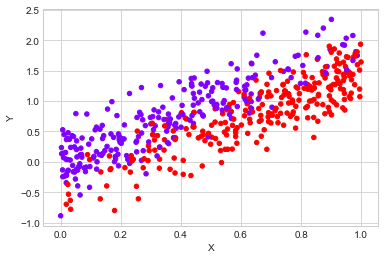

In [7]:
example_smk.plot.scatter(x="X", y="Y", c="A", cmap="rainbow", colorbar=False);

Before jumping into modelling the counterfactual, let's look at the data. If we look at how $Y$ is distributed, there appears to be a small difference between the two groups:

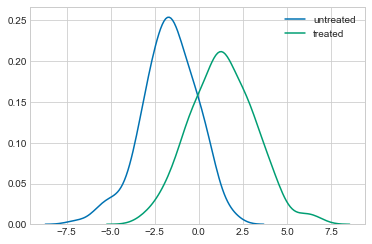

In [5]:
sns.kdeplot(example_smk.loc[lambda df: df.A == 0].Y, label="untreated")
sns.kdeplot(example_smk.loc[lambda df: df.A == 1].Y, label="treated")

If we look at the distribution of the covariance, $X$, it is clear that there is a difference between the groups. 

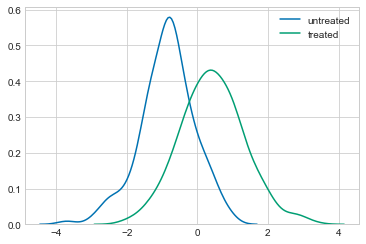

In [6]:
sns.kdeplot(example_smk.loc[lambda df: df.A == 0].X, label="untreated")
sns.kdeplot(example_smk.loc[lambda df: df.A == 1].X, label="treated")

We need some way to disentangle the effect of $A$ on $Y$ and the effect of $X$ on $Y$.

The simplest type of model we can use is a linear model. Specifically we could assume 

$Y^{0}_i = \beta_{0} + \beta_{1} X + \epsilon_i$

$Y^{1}_i = Y^{0}_i + \theta$

If these models are correctly specified, we can fit the following model to the observational data

$Y_i = \beta_0 + \beta_1 X_i + \theta A_i + \epsilon_i$

gives us an estimate of the ATE.

The [`causalinference`](https://pypi.org/project/CausalInference/) package gives us a simple interface to do this:

In [7]:
from causalinference import CausalModel

cm = CausalModel(
    Y=example_smk.Y.values, 
    D=example_smk.A.values, 
    X=example_smk.X.values)

cm.est_via_ols(adj=1)
print(cm.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.475      0.035     13.443      0.000      0.406      0.544



The regression based method yields a good estimate of ATE.